# HW3-B. Defining an Encoder-Decoder model

## About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (06/03/2024)

**Requirements:**
- Python 3
- Matplotlib
- Numpy
- Pandas
- Torch
- Torchmetrics

In [61]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Helper functions (additional file)
from helper_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-block alert-info">
<b>An important note: While usually not advised, you might want to run the code for this homework using CPU only. <br>
It remains possible, however, to use GPU, but we would advise against it, until we have been able to clarify the reason for bugs (most likely some CUDA reason). </b> 
</div> 

In [62]:
# For windows/linux will try CUDA, for Apple devices will try MPS 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 0. Dataset and Dataloaders from earlier

We start by loading our dataset from the Excel file, and reuse our Dataset and Dataloader objects from HW3-A.

In [63]:
# Load dataset from file
excel_file_path = 'data/weather_data_1hr.csv'
times, temperatures = load_dataset(excel_file_path)

In [64]:
class CustomDataset(Dataset):
    # Reuse your code from Notebook 3A

In [65]:
# Create our PyTorch Dataset object from the class above
n_inputs = 168
n_outputs = 24
pt_dataset = CustomDataset(times, temperatures, n_inputs, n_outputs)

In [66]:
# Define batch size
batch_size = 128

# Create DataLoader object
pt_dataloader = # Reuse code from 3A

## 1. Step 1: Designing an Encoder model

We propose to approach this task, by using and Encoder-Decoder model of some sort. Both the Encoder and Decoder parts of the model will consist of a simple LSTM.

**Question 6:** What is a Seq2Seq model, and how does it relate to Encoder-Decoder models?

We want to implement the LSTM architecture drawn below. Its objective is to receives entire $ x(t), x(t+1), ..., x(t+167) $, 168 input points, and learn the dynamics of the data, in the hopes that we will later be able to use this information for future predictions.

<img title="Our Encoder Architecture" alt="Our Encoder Architecture" src="./images/Picture1.png" width="60%">

Given the LSTM Architecture above, answer the questions below.

**Question 7:** This encoder seems to receive all inputs present in the first tensor coming from the Dataloader object, which includes n_inputs elements. This LSTM could then produce 168 outputs, but for some reason, they are not used or even returned. What is the reason for this omission? What information in contained in the final memory vector that will come out of this encoder model?

We want our Encoder model to be represented by the EncoderRNN object, whose class prototype is shown below.

**Question 8:** There are a few Nones to be replaced in the code below. Please show your code in your report after you have figured out the correct EncoderRNN class.

In [67]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = False)

    def forward(self, inputs):
        output, hidden = None
        
        # Return the final hidden state to be used by the decoder
        return None

In [68]:
# Defining our EncoderRNN model
hidden_size = 64
encoder_model = EncoderLSTM(1, hidden_size)
print(encoder_model)

EncoderLSTM(
  (lstm): LSTM(1, 64)
)


**Question 9:** Consider the cell below. What is the shape of *vec1\[0\]* and *vec2\[0\]*? What information do they contain?


In [69]:
# Testing our EncoderRNN model
inputs, _ = next(iter(pt_dataloader))
inputs = inputs.unsqueeze(-1).permute(1, 0, 2)
print(inputs.shape)
encoder_out = encoder_model(inputs[-1:])
vec1, vec2 = encoder_out
print(vec1[0])
print(vec2[0])

torch.Size([168, 128, 1])
tensor([[-0.2524, -0.5302,  0.1606,  ..., -0.1419,  0.0908,  0.3070],
        [-0.2493, -0.5147,  0.1630,  ..., -0.1477,  0.0955,  0.3098],
        [-0.2456, -0.4980,  0.1650,  ..., -0.1533,  0.1003,  0.3117],
        ...,
        [-0.2493, -0.5147,  0.1630,  ..., -0.1477,  0.0955,  0.3098],
        [-0.2697, -0.6805,  0.1041,  ..., -0.0564,  0.0344,  0.2182],
        [-0.2493, -0.5147,  0.1630,  ..., -0.1477,  0.0955,  0.3098]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[-0.6218, -0.8143,  0.5900,  ..., -0.1773,  0.2436,  0.3463],
        [-0.6082, -0.7954,  0.5767,  ..., -0.1873,  0.2541,  0.3535],
        [-0.5935, -0.7747,  0.5624,  ..., -0.1973,  0.2644,  0.3602],
        ...,
        [-0.6082, -0.7954,  0.5767,  ..., -0.1873,  0.2541,  0.3535],
        [-0.7541, -0.9607,  0.7268,  ..., -0.0611,  0.1089,  0.2246],
        [-0.6082, -0.7954,  0.5767,  ..., -0.1873,  0.2541,  0.3535]],
       device='cuda:0', grad_fn=<SelectBackward0>)


## 2. Step 2: Designing a Decoder model

Our next step is to produce a decoder model. It will receive a certain memory vector as its memory starting point. It may also receive 24 inputs denoted *in1*, ... and *in24*. It will then attempt to produce 24 outputs denoted *out1*, ... and *out24*.

We aim to design the Decoder architecture which could supporting both auto-regressive and non-auto-regressive decoding, according to if we provide the target values or not. (Normally we would provide the target values during training which is called teacher-forcing and will not provide target values during predicting).
Consider the architecture drawn below and answer the following questions.

As you can see, it will receive certain input values $in_k$ and will attempt to predict a value $out_k$, with k in $ [1, 24] $.

<img title="Our Decoder Architecture" alt="Our Decoder Architecture" src="./images/Picture2.png" width="60%" >
<img title="Our Decoder Architecture" alt="Our Decoder Architecture" src="./images/Picture3.png" width="60%" >


**Question 10:** Assuming that the encoder has seen the inputs $ x(t), x(t+1), ... x(t+167) $, what should we use as a memory vector to play the role of the memory starting point for the decoder?

**Question 11:** We will use a Decoder that is auto-regressive when not given *target*. What does that mean for the input and output values of our Decoder LSTM-based model?

**Question 12:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+167) $, which values should we use in place for $in_k$? Remember Q11, we are planning to use an auto-regressive decoder here.

**Question 13:** Assuming that the encoder has seen the inputs corresponding to the sample with index $ t $, i.e. $ x(t), x(t+1), ... x(t+167) $, what are the target values should we are trying to match with our predictions in place for $out_k$?

**Question 14:** What is then the purpose and the expected use for the Linear layer in self.linear? Why there is a for loop in the forward method?

**Question 15:** Having figured out the questions in Q10-14, can you figure what to use in place of the Nones in the code for the DecoderRNN below? Show your final code in your report.

In [70]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.output_size = output_size
        self.lstm = nn.LSTM(output_size, hidden_size, batch_first = False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, output_length, target=None):
        outputs = []
        decoder_input = x
        for i in range(output_length):
            # Generate one time step prediction
            # Feed the current prediction as the next input
            decoder_input, hidden = None
            decoder_input = None
            outputs.append(decoder_input)
            if target is not None:
                decoder_input = None
        return torch.cat(outputs, dim = 0)

In [71]:
# Defining our DecoderRNN model
decoder_model = DecoderLSTM(hidden_size = hidden_size, output_size = 1)
print(decoder_model)

DecoderLSTM(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


**Question 16:** Consider the cell below. What should the final size of the *decoder_out* tensor be?


In [72]:
# Testing our DecoderRNN model
inputs, outputs = next(iter(pt_dataloader))
inputs = inputs.unsqueeze(-1).permute(1, 0, 2)

encoder_out = encoder_model(inputs[:-1])
decoder_out = decoder_model(inputs[-1:], encoder_out, n_outputs)
print(decoder_out.shape)

torch.Size([24, 128, 1])


## Step 3: Assembling everything into a Seq2Seq model.

Our final objective is to assemble both our encoder model and decoder model into a Seq2Seq model, following the architecture drawn below.

<img title="Our Seq2Seq Architecture" alt="Our Seq2Seq Architecture" src="./images/Picture4.png" width="60%">

**Question 17:** Why have we preferred to use a Decoder-Encoder architecture, instead of a single LSTM that would receive 168 inputs, produce 24 outputs, and would only compare the final 24 predicted values to the ground truth in our dataset?

**Question 18:** Having figured out the models in EncoderRNN and DecoderRNN, can you now figure out the missing code in the cell below? Show it in your report.

In [73]:
class Seq2Seq(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.output_length = output_size
        self.encoder = EncoderLSTM(1, hidden_size)
        self.decoder = DecoderLSTM(hidden_size, 1)

    def forward(self, inputs, outputs = None):
        hidden = None
        decoder_input = inputs[-1:]
        output = None
        return output

In [74]:
# Defining our Seq2Seq model
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs)
print(seq2seq_model)

Seq2Seq(
  (encoder): EncoderLSTM(
    (lstm): LSTM(1, 64)
  )
  (decoder): DecoderLSTM(
    (lstm): LSTM(1, 64)
    (linear): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [75]:
# Testing our Seq2Seq model
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs)

inputs, outputs = next(iter(pt_dataloader))
inputs = inputs.unsqueeze(-1).permute(1, 0, 2)
outputs = outputs.unsqueeze(-1).permute(1, 0, 2)
print(inputs.shape, outputs.shape)

seq2seq_out = seq2seq_model(inputs)
print(seq2seq_out.shape)

torch.Size([168, 128, 1]) torch.Size([24, 128, 1])
torch.Size([24, 128, 1])


## Step 4: Finally, training and evaluating our Seq2Seq model

**Question 19:** Given your understanding of the task, which (very simple) loss function should we use in our trainer function? Show your updated code in your report.

In [76]:
def train(dataloader, model, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()
    criterion = None
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, outputs in dataloader:
            inputs = inputs.to(device)
            outputs = outputs.to(device)
            inputs = inputs.unsqueeze(-1).permute(1, 0, 2)
            outputs = outputs.unsqueeze(-1).permute(1, 0, 2)
            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs, outputs)
            # Calculate loss
            loss = criterion(pred, outputs)
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print total loss every few epochs
        if epoch % 25 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Avg Loss: {total_loss / len(dataloader)}')

Having figure out the correct models and trainer function, you may not use the celml below. It will train the model from scratch, on 50 iterations and will show you the amount of time take to train this model. This is just information to let you know how long the full training loop (in the next cell), might take on your machine!

In [77]:
# Training the model
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 51, learning_rate = 1e-3)

Epoch 1/51, Avg Loss: 375.85137329101565
Epoch 26/51, Avg Loss: 24.055384826660156
Epoch 51/51, Avg Loss: 6.465337657928467
8.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [78]:
# This was used to save a starting point for the next cell, do not run.
torch.save(seq2seq_model.state_dict(), 'seq2seq_model_start.pth')

**Question 20:** It seems the loss values we are seeing when using the model with randomly initialized parameters is very high. While it seems to decrease, it seems lots of iterations will be needed. The next cell suggests to run the training loop, but initialize the weights of the model using values in the *seq2seq_model_start.pth* file, presumably coming from another roughly similar model, trained on a different but similar task. This is done in an attempt to help the model train better and faster. Under which name is this concept known in Deep Learning?


In [79]:
# Training the model
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
# Start from given parameters to make training easier
seq2seq_model.load_state_dict(torch.load('seq2seq_model_start.pth'))
%timeit -r 1 -n 1 train(dataloader = pt_dataloader, model = seq2seq_model, num_epochs = 1051, learning_rate = 1e-3)

Epoch 1/1051, Avg Loss: 5.9171754121780396
Epoch 26/1051, Avg Loss: 0.6652585685253143
Epoch 51/1051, Avg Loss: 0.39571928381919863
Epoch 76/1051, Avg Loss: 0.32402953803539275
Epoch 101/1051, Avg Loss: 0.30092358887195586
Epoch 126/1051, Avg Loss: 0.2636663198471069
Epoch 151/1051, Avg Loss: 0.25022079348564147
Epoch 176/1051, Avg Loss: 0.2403230756521225
Epoch 201/1051, Avg Loss: 0.22484710961580276
Epoch 226/1051, Avg Loss: 0.2193489208817482
Epoch 251/1051, Avg Loss: 0.20618805289268494
Epoch 276/1051, Avg Loss: 0.1936468079686165
Epoch 301/1051, Avg Loss: 0.19253854751586913
Epoch 326/1051, Avg Loss: 0.17931028753519057
Epoch 351/1051, Avg Loss: 0.17173972278833388
Epoch 376/1051, Avg Loss: 0.16311641782522202
Epoch 401/1051, Avg Loss: 0.15377664864063262
Epoch 426/1051, Avg Loss: 0.1522019937634468
Epoch 451/1051, Avg Loss: 0.1476746216416359
Epoch 476/1051, Avg Loss: 0.1392982617020607
Epoch 501/1051, Avg Loss: 0.13976762294769288
Epoch 526/1051, Avg Loss: 0.13303359746932983
Ep

In [80]:
# Do not uncomment and execute, this was used to prepare the model that you will be using in the final question!
torch.save(seq2seq_model.state_dict(), 'seq2seq_model_end.pth')

**Question 21:** The code below shows the predictions produced by your Seq2Seq model after training and can be used to confirm that you have trained the right model! Show some screenshots in your report, and discuss the final performance you have obtained for your model. For your information, I typically obtain an MSE of ~0.05 after 1000 iterations of training. Additional performance can probably be obtained via hyperparameters tuning (changing the size of memory vector, etc.).

In [81]:
# Quick check on our Seq2Seq model
# (Seeding for reproducibility)
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_model_end.pth'))
seed_value = 187
test_model(seq2seq_model, pt_dataloader, seed_value)

Ground truth:  [[27. 28. 29. 31. 31. 32. 32. 32. 31. 31. 29. 28. 26. 26. 25. 25. 25. 25.
  25. 24. 24. 23. 24. 25.]]
Prediction:  [[26.753567 28.145777 29.51847  30.865696 31.54961  31.975618 32.160362
  31.81448  31.21054  30.63227  29.250906 27.527042 26.295998 25.457466
  24.91557  24.656603 24.59483  24.464573 24.03062  23.386595 22.925545
  23.08804  24.061546 25.787003]]
MAE:  0.53485787


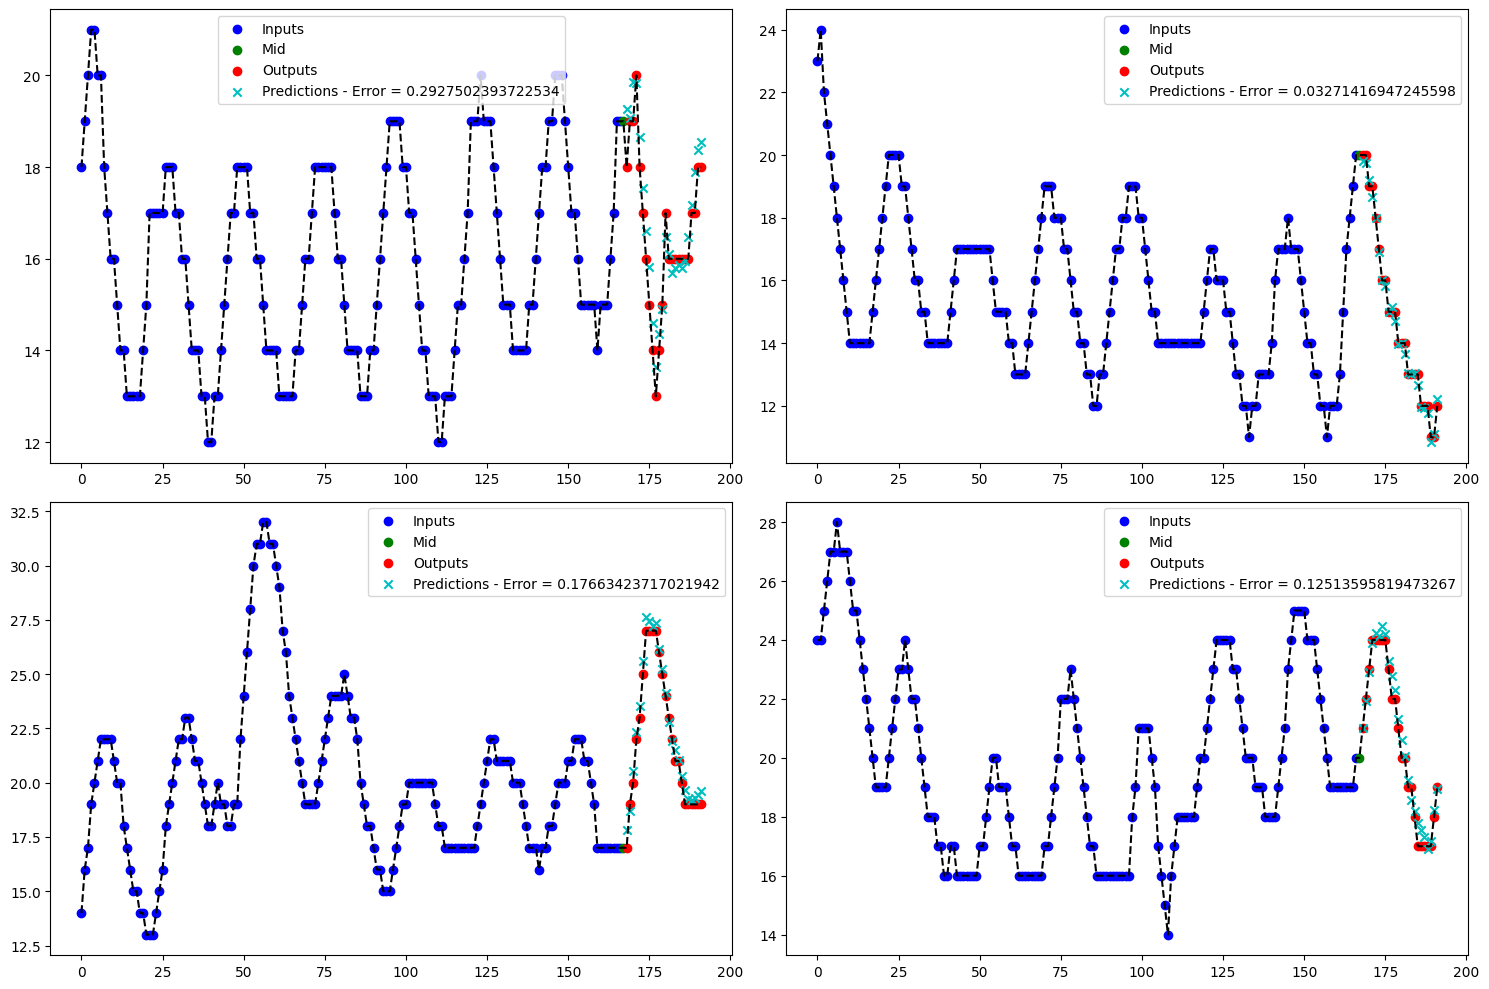

In [82]:
# Reload the model
# (Seeding for reproducibility)
def visualize_some_predictions(model, dataloader):
    fig, axs = plt.subplots(2, 2, figsize = (15, 10))
    
    index1 = 2486
    ax = axs[0, 0]
    torch.manual_seed(index1)
    torch.cuda.manual_seed(index1)
    torch.cuda.manual_seed_all(index1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(index1)
    inputs1, outputs1 = next(iter(dataloader))
    inputs1 = inputs1.unsqueeze(-1).permute(1, 0, 2)
    outputs1 = outputs1.unsqueeze(-1).permute(1, 0, 2)

    pred1 = model(inputs1)
    inputs1, outputs1, mid1 = inputs1.detach().cpu().numpy()[:-1, 64], outputs1.detach().cpu().numpy()[:, 64], inputs1[-1, 64].unsqueeze(0).detach().cpu().numpy()
    pred1 = pred1.detach().cpu().numpy()[:, 64]
    times1 = [i for i in range(len(inputs1))]
    times2 = [len(inputs1)]
    times3 = [len(inputs1) + i + 1 for i in range(len(outputs1))]
    ax.scatter(times1, inputs1, label = "Inputs", c = "b")
    ax.scatter(times2, mid1, label = "Mid", c = "g")
    ax.scatter(times3, outputs1, label = "Outputs", c = "r")
    err = np.mean((outputs1 - pred1)**2)
    ax.scatter(times3, pred1, label = "Predictions - Error = {}".format(err), c = "c", marker = "x")
    ax.plot(times1 + times2 + times3, np.concatenate([inputs1, mid1, outputs1]),  "k--")
    ax.legend(loc = "best")

    index1 = 2986
    ax = axs[0, 1]
    torch.manual_seed(index1)
    torch.cuda.manual_seed(index1)
    torch.cuda.manual_seed_all(index1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(index1)
    inputs1, outputs1 = next(iter(dataloader))
    inputs1 = inputs1.unsqueeze(-1).permute(1, 0, 2)
    outputs1 = outputs1.unsqueeze(-1).permute(1, 0, 2)
    pred1 = model(inputs1)
    inputs1, outputs1, mid1 = inputs1.detach().cpu().numpy()[:-1, 64], outputs1.detach().cpu().numpy()[:, 64], inputs1[-1, 64].unsqueeze(0).detach().cpu().numpy()
    pred1 = pred1.detach().cpu().numpy()[:, 64]
    times1 = [i for i in range(len(inputs1))]
    times2 = [len(inputs1)]
    times3 = [len(inputs1) + i + 1 for i in range(len(outputs1))]
    ax.scatter(times1, inputs1, label = "Inputs", c = "b")
    ax.scatter(times2, mid1, label = "Mid", c = "g")
    ax.scatter(times3, outputs1, label = "Outputs", c = "r")
    err = np.mean((outputs1 - pred1)**2)
    ax.scatter(times3, pred1, label = "Predictions - Error = {}".format(err), c = "c", marker = "x")
    ax.plot(times1 + times2 + times3, np.concatenate([inputs1, mid1, outputs1]),  "k--")
    ax.legend(loc = "best")

    index1 = 3486
    ax = axs[1, 0]
    torch.manual_seed(index1)
    torch.cuda.manual_seed(index1)
    torch.cuda.manual_seed_all(index1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(index1)
    inputs1, outputs1 = next(iter(dataloader))
    inputs1 = inputs1.unsqueeze(-1).permute(1, 0, 2)
    outputs1 = outputs1.unsqueeze(-1).permute(1, 0, 2)
    pred1 = model(inputs1)
    inputs1, outputs1, mid1 = inputs1.detach().cpu().numpy()[:-1, 64], outputs1.detach().cpu().numpy()[:, 64], inputs1[-1, 64].unsqueeze(0).detach().cpu().numpy()
    pred1 = pred1.detach().cpu().numpy()[:, 64]
    times1 = [i for i in range(len(inputs1))]
    times2 = [len(inputs1)]
    times3 = [len(inputs1) + i + 1 for i in range(len(outputs1))]
    ax.scatter(times1, inputs1, label = "Inputs", c = "b")
    ax.scatter(times2, mid1, label = "Mid", c = "g")
    ax.scatter(times3, outputs1, label = "Outputs", c = "r")
    err = np.mean((outputs1 - pred1)**2)
    ax.scatter(times3, pred1, label = "Predictions - Error = {}".format(err), c = "c", marker = "x")
    ax.plot(times1 + times2 + times3, np.concatenate([inputs1, mid1, outputs1]),  "k--")
    ax.legend(loc = "best")

    index1 = 3986
    ax = axs[1, 1]
    torch.manual_seed(index1)
    torch.cuda.manual_seed(index1)
    torch.cuda.manual_seed_all(index1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(index1)
    inputs1, outputs1 = next(iter(dataloader))
    inputs1 = inputs1.unsqueeze(-1).permute(1, 0, 2)
    outputs1 = outputs1.unsqueeze(-1).permute(1, 0, 2)
    pred1 = model(inputs1)
    inputs1, outputs1, mid1 = inputs1.detach().cpu().numpy()[:-1, 64], outputs1.detach().cpu().numpy()[:, 64], inputs1[-1, 64].unsqueeze(0).detach().cpu().numpy()
    pred1 = pred1.detach().cpu().numpy()[:, 64]
    times1 = [i for i in range(len(inputs1))]
    times2 = [len(inputs1)]
    times3 = [len(inputs1) + i + 1 for i in range(len(outputs1))]
    ax.scatter(times1, inputs1, label = "Inputs", c = "b")
    ax.scatter(times2, mid1, label = "Mid", c = "g")
    ax.scatter(times3, outputs1, label = "Outputs", c = "r")
    err = np.mean((outputs1 - pred1)**2)
    ax.scatter(times3, pred1, label = "Predictions - Error = {}".format(err), c = "c", marker = "x")
    ax.plot(times1 + times2 + times3, np.concatenate([inputs1, mid1, outputs1]),  "k--")
    ax.legend(loc = "best")

    plt.tight_layout()
    plt.show()
    
hidden_size = 64
seq2seq_model = Seq2Seq(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_model_end.pth'))
# Visualize
visualize_some_predictions(seq2seq_model, pt_dataloader)

## This concludes HW3.

Do not give up, it is a feasible task! If your model does not work, most likely, you are making a mistake in the Encoder model or - most likely - the Decoder model. Take your time to think about the task at hand and the model we should use for that task.